In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# remove all warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
# Setting the seed for Python, NumPy, and PyTorch (both CPU and GPU)
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # if using CUDA
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disables the auto-tuner that finds the best algorithm

# Call this function before using any random number generators
set_seed(42)

In [4]:
# Function to normalize the image
def normalize_image(image_tensor):
    image_tensor = image_tensor.float() / 255.0
    return image_tensor

# Function to denormalize the image
def denormalize_image(image_tensor):
    denormalized_image = image_tensor * 255.0
    return denormalized_image.to(torch.float)

def mask_image(image, mask_proportion=0.1, mask_value = float('nan')):
    if not isinstance(image, torch.Tensor):
        raise TypeError("Input 'image' must be a torch.Tensor.")
    
    if not (0 <= mask_proportion <= 1):
        raise ValueError("'mask_proportion' must be between 0 and 1.")
    
    img_copy = image.clone()
    mask = torch.rand(image.shape) < mask_proportion
    img_copy[mask] = mask_value
    return img_copy, mask

def load_image(image_path, crop_size=600):
    color_img = torchvision.io.read_image(image_path)
    color_img = color_img.to(dtype=torch.float32)
    # Normalize the image
    color_img = normalize_image(color_img)
    gray_img = torch.tensor(color_img, dtype=torch.float)
    gray_img = gray_img.mean(dim=0, keepdim=False)
    crop = torchvision.transforms.CenterCrop(crop_size)
    img_cropped = crop(gray_img)
    return img_cropped


def matrix_factorization(image_tensor, rank, learning_rate=0.01, num_epochs=5000, tol = 1e-6, device=torch.device("cpu")):
    """
    Perform matrix factorization using Alternating Least Squares (ALS) algorithm.
    
    Args:
        image_tensor (torch.Tensor): The image tensor to be factorized.
        rank (int): The rank of the factorization.
        learning_rate (float): The learning rate for optimization.
        num_epochs (int): The number of epochs to train the model.
        tol (float): The tolerance for convergence.
        device (torch.device): The device to run the optimization.
    
    Returns:
        W (torch.Tensor): The basis matrix.
        H (torch.Tensor): The coefficient matrix.
        loss (torch.Tensor): The final loss.
        losses (list): The list of losses at each epoch.
    """

    image_tensor = image_tensor.to(device)
    height, width = image_tensor.shape
    # Initialize the factors randomly
    W = torch.randn(height, rank, requires_grad=True, device=device)
    H = torch.randn(rank, width, requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=learning_rate)
    mask = ~torch.isnan(image_tensor)
    # Train the model
    losses = []
    prev_loss = float('inf')
    for i in range(1, num_epochs+1):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - image_tensor
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        losses.append(loss.item())
        if i % 1000 == 0:
            print(f"Iteration {i}, loss: {loss.item()}")

        if abs(prev_loss - loss.item()) < tol:
            print(f"Converged at iteration {i}, loss: {loss.item()}")
            break
        prev_loss = loss.item()
        
        # Zero the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    return W, H, loss, losses


def plot_images(original, masked, reconstructed,rank, mask_value):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Image Reconstruction with Rank={rank} and Mask={mask_value}")
    # Original image
    axes[0].imshow(original.cpu().detach().numpy(), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    # Masked image
    axes[1].imshow(masked.cpu().detach().numpy(), cmap='gray')
    axes[1].set_title("Masked Image")
    axes[1].axis('off')
    # Reconstructed image
    axes[2].imshow(reconstructed.cpu().detach().numpy(), cmap='gray')
    axes[2].set_title("Reconstructed Image")
    axes[2].axis('off')
    plt.show()


def calculate_rmse_psnr(original, reconstructed):
    # Ensure both tensors are on the same device
    if original.device != reconstructed.device:
        original = original.to(reconstructed.device)   
    mse = F.mse_loss(reconstructed, original)
    rmse = torch.sqrt(mse)
    print(f"RMSE: {rmse.item()}")
    
    # PSNR: Peak Signal to Noise Ratio
    max_pixel_value = 1.0  # Since image is normalized to [0,1]
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    print(f"PSNR: {psnr.item()}")

    return rmse.item(), psnr.item()

In [5]:
def image_reconstruction_random(image_tensor, rank, mask_proportion=0.1, learning_rate=0.01, num_epochs=5000, tol=1e-6, device=torch.device("cpu")):
    """
    Perform image reconstruction using random masking and matrix factorization.
    Args:
        image_tensor (torch.Tensor): The input image tensor to be reconstructed.
        rank (int): The rank for matrix factorization.
        mask_proportion (float, optional): The proportion of the image to mask. Default is 0.1.
        learning_rate (float, optional): The learning rate for matrix factorization. Default is 0.01.
        num_epochs (int, optional): The number of epochs for matrix factorization. Default is 5000.
        tol (float, optional): The tolerance for convergence in matrix factorization. Default is 1e-6.
        device (torch.device, optional): The device to perform computations on. Default is CPU.
    Returns:
        reconstructed (torch.Tensor): The reconstructed image tensor.
        masked_img (torch.Tensor): The masked image tensor.
        loss (float): The final loss value after matrix factorization.
        losses (list): The list of loss values over epochs.
        rmse (float): The Root Mean Square Error between the original and reconstructed image.
        psnr (float): The Peak Signal-to-Noise Ratio between the original and reconstructed image.
    """
    
    image_tensor = image_tensor.to(device)
    # Mask the image
    masked_img, mask = mask_image(image_tensor, mask_proportion)
    # Factorize the masked_img image
    W, H, loss, losses = matrix_factorization(masked_img, rank, learning_rate, num_epochs, tol, device)
    # Reconstruct the image
    reconstructed = torch.mm(W, H)
    # Clamp the images to [0, 1]
    reconstructed = torch.clamp(reconstructed, 0, 1)
    # Calculate RMSE and PSNR
    rmse, psnr = calculate_rmse_psnr(image_tensor, reconstructed)
    # Plot the original and reconstructed
    plot_images(image_tensor, masked_img, reconstructed, rank, mask_proportion)
    
    return reconstructed, masked_img, loss, losses,  rmse, psnr


Iteration 1000, loss: 8.281551361083984
Iteration 2000, loss: 6.007095813751221
Iteration 3000, loss: 5.00153112411499
Iteration 4000, loss: 4.404287815093994
Iteration 5000, loss: 3.9948184490203857
Iteration 6000, loss: 3.6968631744384766
Converged at iteration 6313, loss: 3.6212570667266846
RMSE: 0.11781685054302216
PSNR: 18.575851440429688


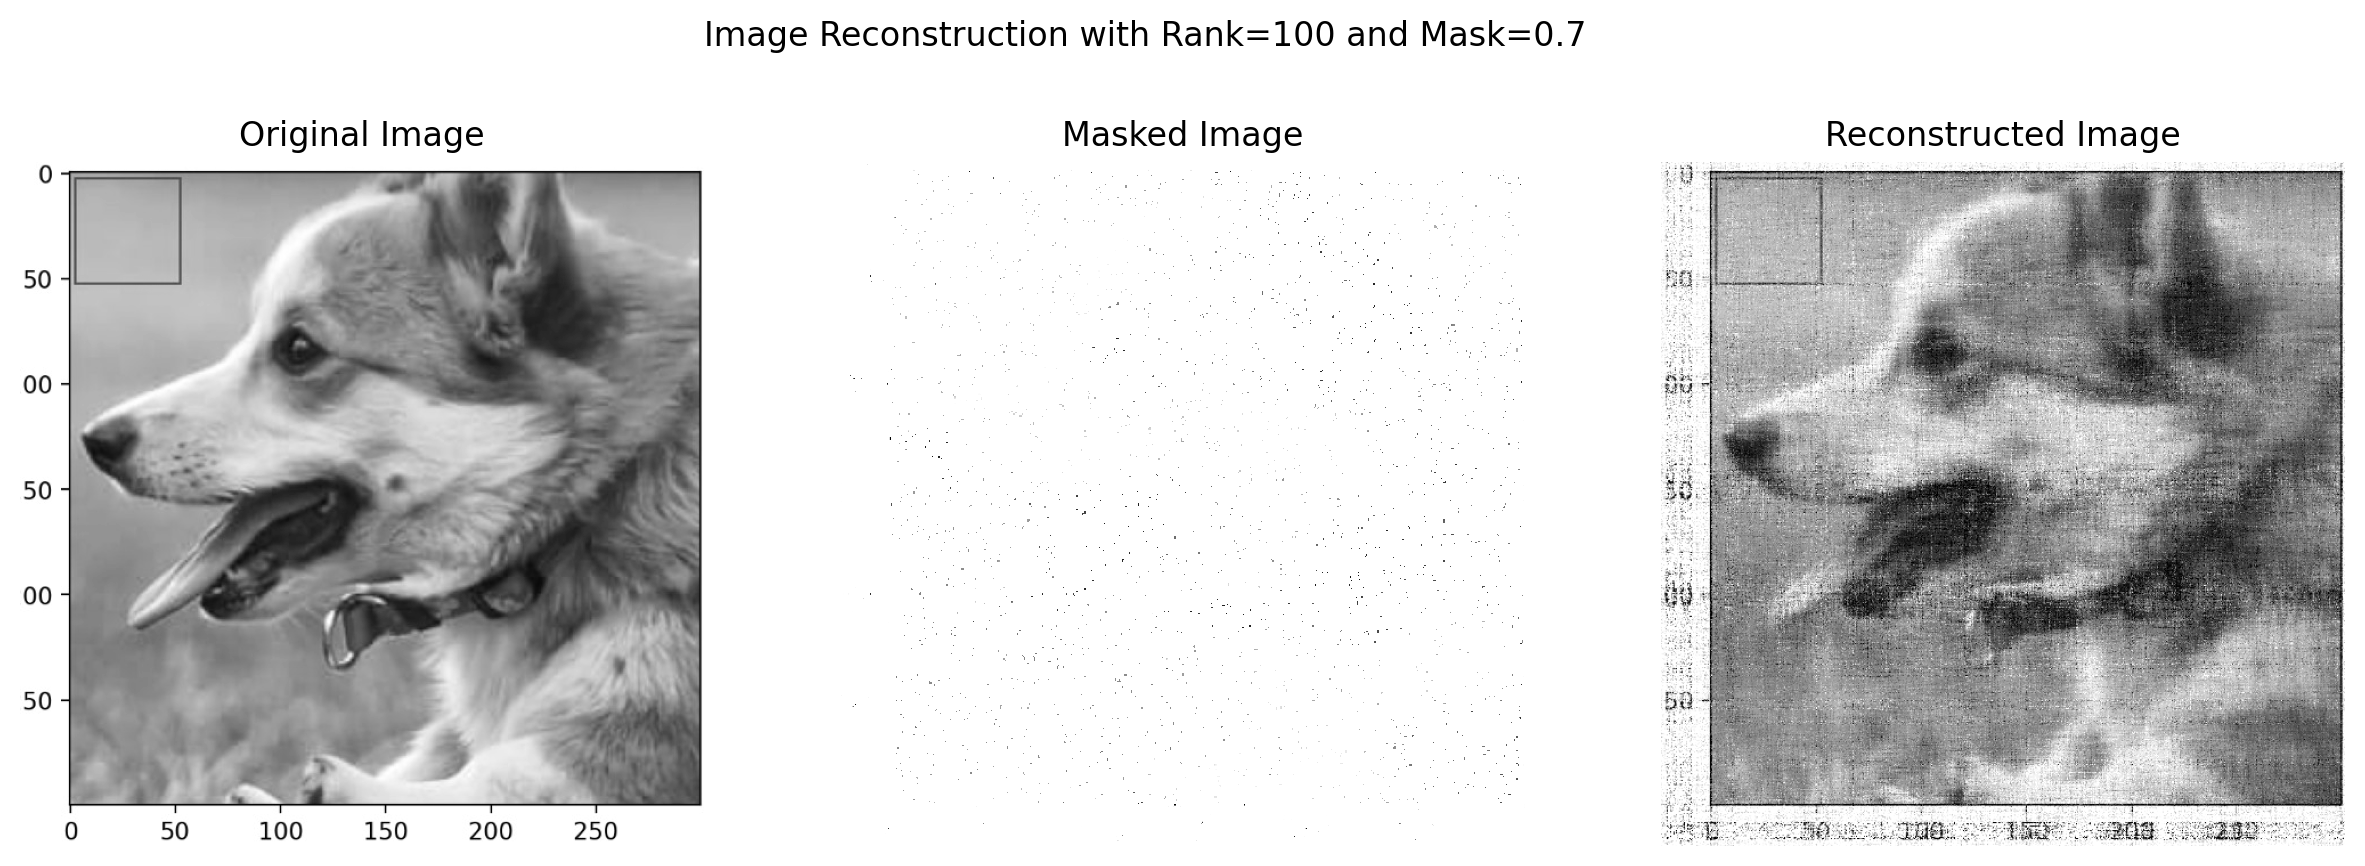

In [11]:
# load image
img_cropped = load_image('../sample_images/1colour.jpg', crop_size=600)

reconstructed_img, masked_img, loss, losses, rmse, psnr = image_reconstruction_random(img_cropped, 100, mask_proportion=0.7, learning_rate=0.01, num_epochs=10000, device=device)